# Parametric UMAP Classifier Tutorial
Parametric UMAP is an extension of UMAP, which learns the embedding with a neural network. In this tutorial, we show how this is done in practice, how the training is controled and monitored and how costum networks can be implemented. For a general tutorial on using the UMAP Classifier see the [UMAP Classifier Tutorial](01_umap_classifier.ipynb).

>General network infrastructure of a Parametric UMAP model\
\
<img src=".figures/pumap.png" alt="Converted PDF" height="200">

In [24]:
# imports
import sys
sys.path.insert(0, '../../')
import numpy as np
import joblib
from matplotlib import pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc
from helper_scripts import random_rm_trace_generator
from src.rm_classifier import parametric_umap_classifier
from src.rm_classifier import performance_metrics as pm

In [2]:
# Load example data and split into training and test set
time_traces, spectra, phase, true_clusters, time_axis,freq_axis=random_rm_trace_generator.generate_random_rm_traces(
    400, n_clusters=5, outlier_fraction=0.05, noise_level=1)
time_traces, test_time_traces, spectra, test_spectra, phase, test_phase, true_clusters, test_true_clusters = train_test_split(
    time_traces, spectra, phase, true_clusters, test_size=0.5, random_state=42)

In [3]:
# initialize parametric UMAP classifier
pu_clas = parametric_umap_classifier.ParametricUMAPClassifier(yaml_path="../yaml_files/umap_classifier_test.yaml")
prepared_data=pu_clas.prepare_data(time_traces, input_data_type="time",  data_preparation={'target_data_type': "fft"}, 
                 log_filter=True,avg_pooling=4,verbose=False,
                 normalization=True,
                 suppress_dc=True)

No rd_train_std provided. Calculating std from the provided prepared data.
No rd_train_std provided. Calculating std from the provided prepared data.


In [ ]:
# embed the prepared data
embeddings=pu_clas.train_embed(prepared_data, 
                         save_model="pumap_model", # path to save the model
                         parametric_reconstruction=True, # enable parametric reconstruction for validation
                         autoencoder_loss=True, # incorporate the autoencoder reconstruction loss into the total loss
                         parametric_reconstruction_loss_weight=2, # weight of the reconstruction loss in the total loss
                         n_training_epochs=20, # number of training epochs
                         batch_size=64, # batch size
                         val_train_split=0.1, # fraction of data to use for validation
                         metric="euclidean",
                         loss_report_frequency=10,
                         verbose=False)

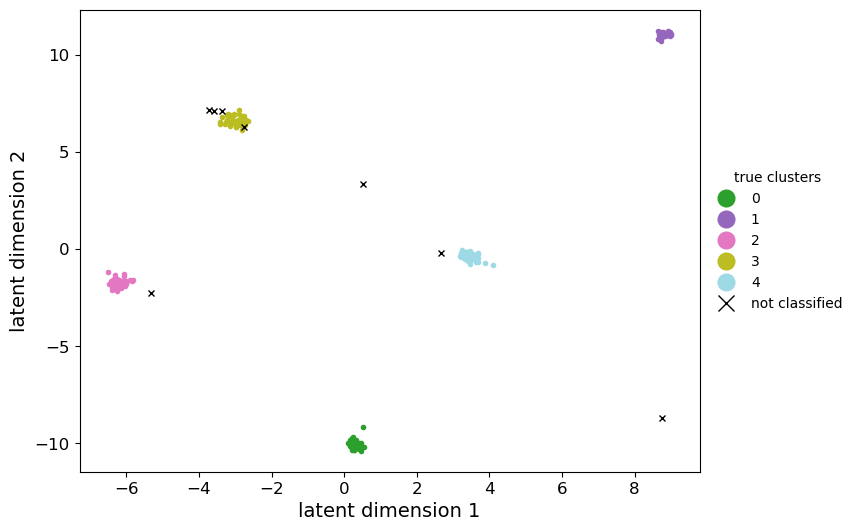

In [5]:
# visualize the embeddings in a 2D scatter plot
fig, ax = pu_clas.plot_embedding(embeddings, labels=true_clusters, label_type='categorical', label_name="true clusters", alpha=1)

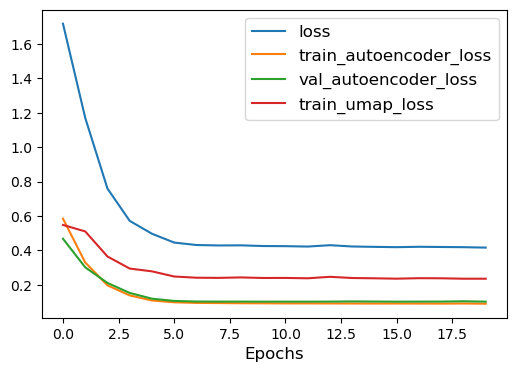

In [6]:
# plot the loss
plt.figure(figsize=(6,4))
history = joblib.load("../models/umap_classifier_1/pumap_model/history.pkl")
for key in history.keys():
    plt.plot(history[key], label=key)
plt.xlabel("Epochs", fontsize=12)
plt.legend(fontsize=12)
plt.show()

> It is also possible to specify a costum network for the encoder and decoder. Especially for high diemnsional inputs convolutional neural networks are often advised in comparison to dense networks. Furthermore, it can be helpful for outlier identification to define a very simple decoder.

In [7]:
# initialize parametric UMAP classifier
pu_clas = parametric_umap_classifier.ParametricUMAPClassifier(yaml_path="../yaml_files/umap_classifier_test.yaml")
prepared_data=pu_clas.prepare_data(time_traces, input_data_type="time",  data_preparation={'target_data_type': "fft"}, 
                 log_filter=True,avg_pooling=4,verbose=False,
                 normalization=True,
                 suppress_dc=True)

No rd_train_std provided. Calculating std from the provided prepared data.
No rd_train_std provided. Calculating std from the provided prepared data.


In [8]:
# define decoder network architecture
decoder = keras.Sequential(
    [
        keras.layers.Input(shape=(2,)),
        keras.layers.Dense(units=100, activation="relu"),
        keras.layers.Dense(units=prepared_data.shape[1], activation="linear"),

    ])

In [9]:
# furthermore, apply keras_fit_kwargs such as early stopping or learning rate reduction on plateau
keras_fit_kwargs = {"callbacks": [
    keras.callbacks.EarlyStopping(
        monitor='val_autoencoder_loss',
        min_delta=1e-4,
        patience=5,
        verbose=1,
        restore_best_weights=True,
        mode="min"

    ),
    keras.callbacks.ReduceLROnPlateau(
    monitor='loss',
    factor=0.5,                   # Reduce LR by half
    patience=2,                   # Wait 2 epochs before reducing
    min_lr=1e-7,                  # Don't go below this
    verbose=1
)
]}

In [ ]:
# embed the prepared data
embeddings=pu_clas.train_embed(prepared_data, 
                         save_model="pumap_model", 
                         parametric_reconstruction=True,
                         autoencoder_loss=True,
                         n_training_epochs=200,
                         decoder=decoder, # pass the decoder network 
                         keras_fit_kwargs=keras_fit_kwargs, # pass the keras fit kwargs
                         verbose=False)

Overriding db_min_samples with value 20 from kwargs.
Automatically determined db_eps: 1.0028346566501172 which is the 0.965 percentile of the 20-distance.


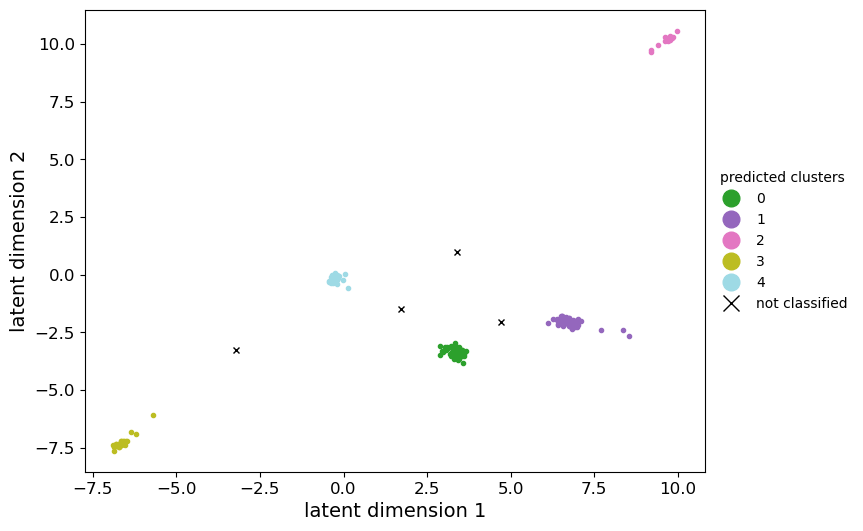

In [11]:
# visualize the embeddings in a 2D scatter plot
db_clusters = pu_clas.db_classify(embeddings, verbose=True, db_min_samples=20, auto_eps=True)
fig, ax = pu_clas.plot_embedding(embeddings, labels=db_clusters, label_type='categorical', label_name="predicted clusters", alpha=1)

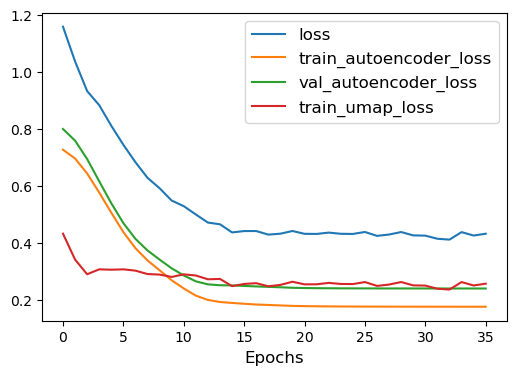

In [12]:
# plot the loss
plt.figure(figsize=(6,4))
history = joblib.load("../models/umap_classifier_1/pumap_model/history.pkl")
for key in history.keys():
    if key != "learning_rate":
        plt.plot(history[key], label=key)
plt.xlabel("Epochs", fontsize=12)
plt.legend(fontsize=12)
plt.show()

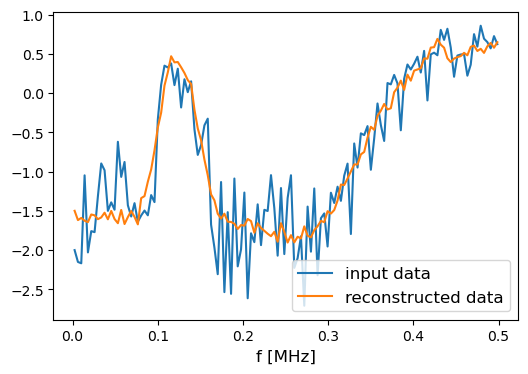

In [ ]:
# Visualize the ability of the parametric UMAP to reconstruct the input data
idx = 5 # test different indices
out_data=pu_clas.reconstruct(prepared_data)
pooled_freq_axis=np.mean(freq_axis[1:].reshape(-1, pu_clas.data_preparation["avg_pooling"]), axis=1)
plt.figure(figsize=(6,4))
plt.plot(pooled_freq_axis, prepared_data[idx], label="input data")
plt.plot(pooled_freq_axis, out_data[idx], label="reconstructed data")
plt.legend(fontsize=12)
plt.xlabel("f [MHz]", fontsize=12)
plt.show()


**Predict Cluster Labels from New Data**
> We can apply the same visualization and prediction methods as for the [UMAP Classifier](umap_classifier.ipynb) in a similar manner. The only slight difference occurs for the UMAPs' transform method. The embedding of new data is here done by the neural network which was trained in the previous steps. This significantly accelerates the embedding of new data. 

In [14]:
# Prepare the test data in the same way as the training data.
# As one can see the parameters for normalization and data preparation are stored as attributes of the instance.
prepared_test_data=pu_clas.prepare_data(test_time_traces, verbose=False)

Using previous rd_train_mean and rd_train_std for normalization.


In [15]:
# Predict clusters for new data
pred_clusters, pred_embeddings, _=pu_clas.pumap_transform_prediction(prepared_test_data, db_eps=2)
np.unique(pred_clusters, return_counts=True)

Transforming data with UMAP model and predicting clusters with DBSCAN (eps=2)
Processing batch 0 to 20000
Creating DBSCAN model


(array([-1,  0,  1,  2,  3,  4]), array([ 4, 33, 40, 45, 39, 39]))

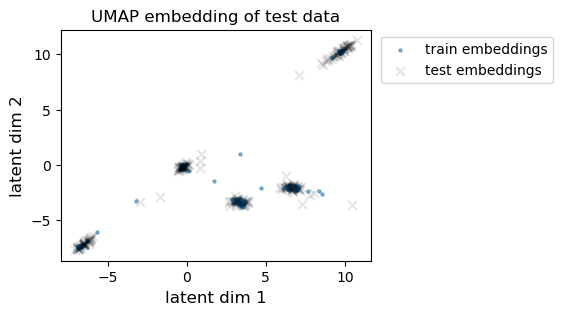

In [16]:
# Plot the embeddings of the test data
plt.figure(figsize=(4,3))
plt.scatter(embeddings[:,0], embeddings[:,1], s=5, label='train embeddings', alpha=0.5)
plt.scatter(pred_embeddings[:,0], pred_embeddings[:,1], s=40, label='test embeddings', alpha=0.1, marker='x', color="k")

plt.title('UMAP embedding of test data')
plt.xlabel('latent dim 1', fontsize=12)
plt.ylabel('latent dim 2', fontsize=12)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.show()

**Outlier Detection**
> Similary, to the UMAP Classifier we can create the ROC curve for identification of new clusters which were not present in the training data.

In [17]:
# Create new data from a cluster not present in the training data
new_time_traces, new_spectra, new_phase, new_true_clusters, _,_=random_rm_trace_generator.generate_random_rm_traces(
    50, n_clusters=1, outlier_fraction=1, noise_level=1)
new_true_clusters=np.repeat(-1, 50)  # Mark all new data as outliers
# Prepare the new data in the same way as the training data.
new_prepared_data=pu_clas.prepare_data(new_time_traces, verbose=False)

Using previous rd_train_mean and rd_train_std for normalization.


In [18]:
%%capture output
# Predict clusters with Parametric UMAP embedding and DBSCAN with different values for db_eps
epsilons = np.logspace(-5, 1, 1000)
fprs, tprs = [], []

# First calculate the embeddings which is costly and should not be done for every value of eps
new_predictions, new_embs, _ = pu_clas.pumap_transform_prediction(new_prepared_data, db_eps=0)
test_predictions, test_embs, _ = pu_clas.pumap_transform_prediction(prepared_test_data[test_true_clusters != -1], db_eps=0)

for eps in epsilons:
    # Set the eps parameter of the existing DBSCAN model to the current value
    pu_clas.db_model.set_params(eps=eps)

    # Predict the cluster labels for the new data and the test data without outliers only by the dbscan_predict method
    new_predictions = pu_clas._dbscan_predict(pu_clas.db_model, new_embs)
    test_predictions = pu_clas._dbscan_predict(pu_clas.db_model, test_embs)
    true_noise_points = sum(new_predictions == -1)
    false_noise_points = sum(test_predictions == -1)
    tprs.append(true_noise_points/len(new_predictions))
    fprs.append(false_noise_points/len(test_predictions))

AUC: 0.9629


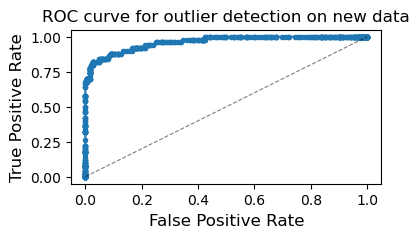

In [19]:
# Plot the ROC curve
plt.figure(figsize=(4,2))
plt.plot(fprs, tprs, ".-")
plt.plot([0,1], [0,1], "--", color="k", alpha=0.5, linewidth=0.8)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC curve for outlier detection on new data')
print(f"AUC: {auc(fprs, tprs):.4f}")
plt.show()

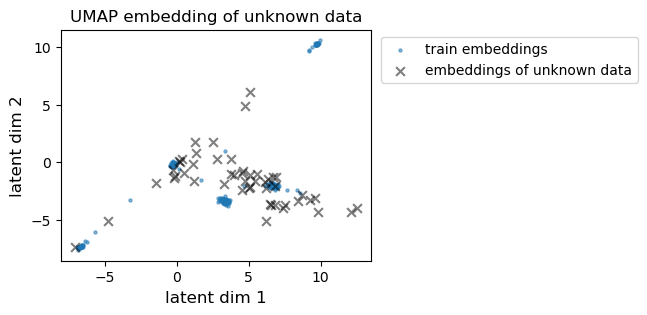

In [20]:
# Plot the embeddings of the unknown data
plt.figure(figsize=(4,3))
plt.scatter(embeddings[:,0], embeddings[:,1], s=5, label='train embeddings', alpha=0.5)
plt.scatter(new_embs[:,0], new_embs[:,1], s=40, label='embeddings of unknown data', alpha=0.5, marker='x', color="k")

plt.title('UMAP embedding of unknown data')
plt.xlabel('latent dim 1', fontsize=12)
plt.ylabel('latent dim 2', fontsize=12)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.show()

> This can already work much better than the UMAP classifiers' transform method if the outliers are very different from the other clusters. However, it might fail in many cases, where the outliers are more similar to data from one specific cluster. This is why we here present another method, which uses the reconstruction loss. \
> This method is especially suited for larger training sets, where new malfunctions possess features, which are not present in the training set.

In [21]:
pu_clas.prepare_pumap_transform_prediction(prepared_data, db_clusters)

Preparing to transform data with Parametric UMAP model and predict clusters with DBSCAN


In [22]:
%%capture output
# Predict clusters with parametric UMAP embedding and DBSCAN 
# identify noise by high reconstruction loss with different values for noise_alpha
alphas = np.logspace(-2, 2, 1000)[::-1]
fprs, tprs = [], []

# Make the cluster assignment including the costly embedding and the calculation of reconstruction loss in advance
# Of course, one can also adjust the noise_alpha in each step, which would be computationally way more expensive
new_predictions, _, new_rec_loss = pu_clas.pumap_transform_prediction(new_prepared_data, rec_loss_noise_detection=True, db_eps=100, noise_alpha=1e10)    
test_predictions, _, test_rec_loss = pu_clas.pumap_transform_prediction(prepared_test_data, rec_loss_noise_detection=True, db_eps=100, noise_alpha=1e10)

for alpha in alphas:

    new_predictions[new_rec_loss > (pu_clas.cluster_median_rec_loss[new_predictions] * alpha)] = -1
    test_predictions[test_rec_loss > (pu_clas.cluster_median_rec_loss[test_predictions] * alpha)] = -1
    true_noise_points = sum(new_predictions == -1)
    false_noise_points = sum(test_predictions == -1)
    tprs.append(true_noise_points/len(new_predictions))
    fprs.append(false_noise_points/len(test_predictions))

AUC: 0.7279


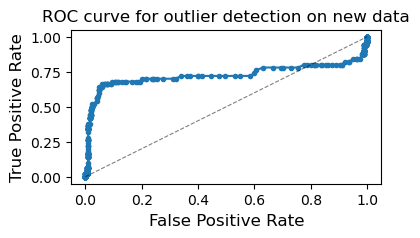

In [23]:
# Plot the ROC curve
plt.figure(figsize=(4,2))
plt.plot(fprs, tprs, ".-")
plt.plot([0,1], [0,1], "--", color="k", alpha=0.5, linewidth=0.8)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC curve for outlier detection on new data')
print(f"AUC: {auc(fprs, tprs):.4f}")
plt.show()